In [ ]:
!pip install google-cloud-storage
!pip install pandas

In [1]:
import numpy as np
import pandas as pd

### keep only quality_index_6 >= 0

In [2]:
df_merge_quality = pd.read_csv('US_patent_abstract_5000_2015_with_title_1.csv')
df_merge_quality.shape

(5000, 30)

In [3]:
max(df_merge_quality['quality_index_4'])

0.9117351596366192

In [4]:
min(df_merge_quality['quality_index_4'])

0.0212197159565581

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

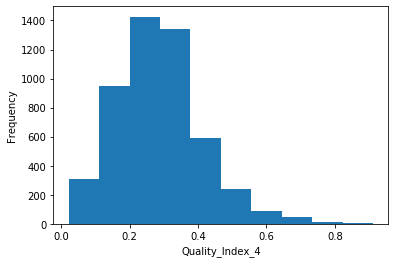

In [6]:
plt.hist(df_merge_quality['quality_index_4'], density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Quality_Index_4');

In [7]:
df_merge_quality

,Unnamed: 0,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,...,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank,text
0,54639,US-8014303-B2,A network device may include logic configured ...,20101229,Systems and methods for interfacing with netwo...,1. A device comprising:\n memory to store inst...,US08014303,333595253,US08014303,2010,...,3,0,0.593750,0.751486,0.137931,5.0,0.250936,0.326616,0,Systems and methods for interfacing with netwo...
1,45032,US-9114955-B2,Provided is a control device for an elevator t...,20101208,Control device for elevator,The invention claimed is: \n \n 1. A...,US09114955,380228413,US09114955,2010,...,4,0,0.619062,0.279297,0.093750,5.0,0.315645,0.289177,1,Control device for elevator. Provided is a con...
2,49357,US-8737855-B2,A plurality of test patches each including a d...,20100927,Image forming apparatus and density unevenness...,What is claimed is: \n \n 1. An imag...,US08737855,333087673,US08737855,2010,...,9,0,0.499528,0.805556,0.583333,4.0,0.254967,0.250367,0,Image forming apparatus and density unevenness...
3,151718,US-8531163-B2,"To provide a switching power supply device, an...",20100312,"Switching power supply device, integrated circ...",The invention claimed is: \n \n 1. A...,US08531163,341889903,US08531163,2010,...,15,0,0.713139,0.830487,0.755102,7.0,0.324680,0.317031,1,"Switching power supply device, integrated circ..."
4,102001,US-9626390-B2,"In one general aspect, a computer system can i...",20101227,Shadow system start during upgrade of an origi...,What is claimed is: \n \n 1. A compu...,US09626390,364671666,US09626390,2010,...,9,0,0.000000,0.786048,0.072000,7.0,0.135417,0.172861,0,Shadow system start during upgrade of an origi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,89503,US-8815989-B2,The invention aims to provide a resin composit...,20101110,Resin composition for coating material,The invention claimed is: \n \n 1. A...,US08815989,376848395,US08815989,2010,...,5,0,0.674311,0.943568,0.471910,4.0,0.325126,0.318887,1,Resin composition for coating material. The in...
4996,42696,US-8704454-B2,A method includes forming one or more capacito...,20101013,Integrated driver system architecture for ligh...,What is claimed is: \n \n 1. A metho...,US08704454,333369342,US08704454,2010,...,3,0,0.592089,0.932416,0.776699,4.0,0.308532,0.309862,1,Integrated driver system architecture for ligh...
4997,105030,US-8809921-B2,A solid-state imaging apparatus includes a plu...,20101222,"Solid-state imaging apparatus, method of manuf...",What is claimed is: \n \n 1. A solid...,US08809921,335867166,US08809921,2010,...,6,0,0.485926,0.723776,0.390244,4.0,0.298260,0.294224,0,"Solid-state imaging apparatus, method of manuf..."
4998,171202,US-9149407-B2,A device for therapeutically treating and/or t...,20100521,Device for therapeutically treating and/or tra...,The invention claimed is: \n \n 1. A...,US09149407,353322751,US09149407,2010,...,6,0,0.284082,0.862222,0.120000,5.0,0.362534,0.304468,1,Device for therapeutically treating and/or tra...


### create a model

In [8]:
import numpy as np
import pandas as pd
import pickle as cPickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

Using TensorFlow backend.


In [9]:
MAX_SENT_LENGTH = 30
MAX_SENTS = 30
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [10]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [11]:
data_train = df_merge_quality

In [12]:
print(data_train.shape)

(5000, 30)


In [13]:
data_train['quality_rank'].value_counts()

0    2896
1    2104
Name: quality_rank, dtype: int64

In [14]:
2896/5000

0.5792

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nobu_yamaguchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
from nltk import tokenize

claims = []
labels = []
texts = []

for idx in range(data_train.text.shape[0]):

    text = clean_str(str(data_train.iloc[idx]['claims_text']))
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    claims.append(sentences)
    labels.append(data_train.iloc[idx]['quality_rank'])

In [17]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [18]:
data.shape

(5000, 30, 30)

In [19]:
for i, sentences in enumerate(claims):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
            #for word in wordTokens:
                if word in tokenizer.word_index.keys():
                    if (k < MAX_SENT_LENGTH) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1

In [20]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 31722 unique tokens.


In [21]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (5000, 30, 30)
Shape of label tensor: (5000, 2)


In [58]:
#indices = np.arange(data.shape[0])
#np.random.shuffle(indices)

In [22]:
#data = data[indices]
#labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [37]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [38]:
print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in traing and validation set
[2320. 1680.]
[576. 424.]


In [39]:
# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display

# NumPy and SciPy for matrix ops

import scipy.sparse


# Helper libraries
#from w266_common import utils, vocabulary, tf_embed_viz
#import glove_helper; reload(glove_helper)

#hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

import zipfile
with zipfile.ZipFile("data/glove/glove.6B.zip", 'r') as zip_ref:
    zip_ref.extractall("data/glove")

In [26]:
GLOVE_DIR = "data/glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [27]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [49]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=False)

In [50]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim, )), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
 
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b)) #

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)


        #if mask is not None:
        #    # Cast the mask to floatX to avoid float64 upcasting in theano
        #    print('mask')
        #    ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        ait = K.expand_dims(ait)
 
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [51]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)

tracking <tf.Variable 'att_layer_5/W:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_5/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_5/u:0' shape=(100, 1) dtype=float32> u


In [52]:
claims_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
claims_encoder = TimeDistributed(sentEncoder)(claims_input)
l_lstm_sent = Bidirectional(GRU(30, return_sequences=True))(claims_encoder)

In [53]:
l_lstm_sent.shape

TensorShape([None, 30, 60])

In [54]:
#l_att_sent = AttLayer(100)(l_lstm_sent)
l_att_sent = AttLayer(100)(l_lstm_sent)

tracking <tf.Variable 'att_layer_6/W:0' shape=(60, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_6/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_6/u:0' shape=(100, 1) dtype=float32> u


In [55]:
l_att_dense = Dense(100, activation='relu')(l_att_sent)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_sent_drop = Dropout(rate=0.2)(l_att_dense)
preds = Dense(2, activation='sigmoid')(l_att_sent_drop)
model = Model(claims_input, preds)

In [56]:
preds.shape

TensorShape([None, 2])

In [57]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [44]:
print("model fitting - Hierachical attention network 0.3")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network 0.3


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 14s 4ms/step - loss: 0.6817 - acc: 0.5739 - val_loss: 0.6860 - val_acc: 0.5640
Epoch 2/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6767 - acc: 0.5831 - val_loss: 0.6846 - val_acc: 0.5640
Epoch 3/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6757 - acc: 0.5825 - val_loss: 0.6838 - val_acc: 0.5650
Epoch 4/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6718 - acc: 0.5804 - val_loss: 0.6839 - val_acc: 0.5675
Epoch 5/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6601 - acc: 0.6060 - val_loss: 0.6884 - val_acc: 0.5385
Epoch 6/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6471 - acc: 0.6164 - val_loss: 0.6821 - val_acc: 0.5445
Epoch 7/10
4000/4000 [==============================] - 11s 3ms/step - loss: 0.6333 - acc: 0.6395 - val_loss: 0.6862 - val_acc: 0.5665
Epoch 8

### We changed max_sentence to 10

In [72]:
print("model fitting - Hierachical attention network - 0.3 Max sentence = 10")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network - 0.3 Max sentence = 6


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 32s 8ms/step - loss: 0.6586 - acc: 0.5811 - val_loss: 0.6518 - val_acc: 0.5730
Epoch 2/10
4000/4000 [==============================] - 27s 7ms/step - loss: 0.6520 - acc: 0.5786 - val_loss: 0.6519 - val_acc: 0.5845
Epoch 3/10
4000/4000 [==============================] - 27s 7ms/step - loss: 0.6512 - acc: 0.5895 - val_loss: 0.6475 - val_acc: 0.6060
Epoch 4/10
4000/4000 [==============================] - 28s 7ms/step - loss: 0.6464 - acc: 0.6056 - val_loss: 0.6496 - val_acc: 0.5830
Epoch 5/10
4000/4000 [==============================] - 28s 7ms/step - loss: 0.6381 - acc: 0.6302 - val_loss: 0.6447 - val_acc: 0.6110
Epoch 6/10
4000/4000 [==============================] - 28s 7ms/step - loss: 0.6363 - acc: 0.6341 - val_loss: 0.6381 - val_acc: 0.6320
Epoch 7/10
4000/4000 [==============================] - 27s 7ms/step - loss: 0.6231 - acc: 0.6515 - val_loss: 0.6368 - val_acc: 0.6300
Epoch 8

In [56]:
print("model fitting - Hierachical attention network  max_sent = 15")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=5, batch_size=50)

model fitting - Hierachical attention network  .3


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 13s 3ms/step - loss: 0.6465 - acc: 0.6551 - val_loss: 0.6522 - val_acc: 0.6390
Epoch 2/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.6405 - acc: 0.6610 - val_loss: 0.6508 - val_acc: 0.6390
Epoch 3/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.6377 - acc: 0.6611 - val_loss: 0.6483 - val_acc: 0.6390
Epoch 4/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.6330 - acc: 0.6599 - val_loss: 0.6472 - val_acc: 0.6370
Epoch 5/5
4000/4000 [==============================] - 10s 2ms/step - loss: 0.6250 - acc: 0.6629 - val_loss: 0.6455 - val_acc: 0.6395


In [37]:
print("model fitting - Hierachical attention network  max_sent = 20")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network  max_sent = 20


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 49s 12ms/step - loss: 0.6416 - acc: 0.6392 - val_loss: 0.6457 - val_acc: 0.6230
Epoch 2/10
4000/4000 [==============================] - 45s 11ms/step - loss: 0.6301 - acc: 0.6575 - val_loss: 0.6401 - val_acc: 0.6430
Epoch 3/10
4000/4000 [==============================] - 45s 11ms/step - loss: 0.6262 - acc: 0.6637 - val_loss: 0.6351 - val_acc: 0.6305
Epoch 4/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6213 - acc: 0.6596 - val_loss: 0.6302 - val_acc: 0.6435
Epoch 5/10
4000/4000 [==============================] - 45s 11ms/step - loss: 0.6132 - acc: 0.6680 - val_loss: 0.6246 - val_acc: 0.6515
Epoch 6/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6025 - acc: 0.6718 - val_loss: 0.6187 - val_acc: 0.6500
Epoch 7/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.5952 - acc: 0.6870 - val_loss: 0.6259 - val_acc: 0.6655


In [50]:
print("model fitting - Hierachical attention network  max_sent = 20")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network  max_sent = 20


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 47s 12ms/step - loss: 0.6452 - acc: 0.6398 - val_loss: 0.6458 - val_acc: 0.6310
Epoch 2/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6336 - acc: 0.6466 - val_loss: 0.6460 - val_acc: 0.6325
Epoch 3/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6255 - acc: 0.6559 - val_loss: 0.6405 - val_acc: 0.6370
Epoch 4/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6160 - acc: 0.6724 - val_loss: 0.6265 - val_acc: 0.6485
Epoch 5/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6135 - acc: 0.6699 - val_loss: 0.6205 - val_acc: 0.6520
Epoch 6/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6017 - acc: 0.6805 - val_loss: 0.6250 - val_acc: 0.6620
Epoch 7/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.5933 - acc: 0.6852 - val_loss: 0.6200 - val_acc: 0.6645


In [72]:
print("model fitting - Hierachical attention network  max_sent = 20 dropout rate = 0.4")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network  max_sent = 20 dropout rate = 0.4


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 47s 12ms/step - loss: 0.6423 - acc: 0.6388 - val_loss: 0.6389 - val_acc: 0.6350
Epoch 2/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6275 - acc: 0.6580 - val_loss: 0.6410 - val_acc: 0.6370
Epoch 3/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6241 - acc: 0.6683 - val_loss: 0.6448 - val_acc: 0.6365
Epoch 4/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6183 - acc: 0.6619 - val_loss: 0.6339 - val_acc: 0.6385
Epoch 5/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6072 - acc: 0.6790 - val_loss: 0.6231 - val_acc: 0.6435
Epoch 6/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6062 - acc: 0.6770 - val_loss: 0.6352 - val_acc: 0.6340
Epoch 7/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.5931 - acc: 0.6908 - val_loss: 0.6217 - val_acc: 0.6360


In [100]:
print("model fitting - Hierachical attention network  max_sent = 20 dropout rate = 0.2")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=50)

model fitting - Hierachical attention network  max_sent = 20 dropout rate = 0.2


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 47s 12ms/step - loss: 0.6426 - acc: 0.6288 - val_loss: 0.6511 - val_acc: 0.6280
Epoch 2/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6323 - acc: 0.6505 - val_loss: 0.6398 - val_acc: 0.6355
Epoch 3/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6276 - acc: 0.6560 - val_loss: 0.6403 - val_acc: 0.6345
Epoch 4/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.6139 - acc: 0.6689 - val_loss: 0.6317 - val_acc: 0.6365
Epoch 5/10
4000/4000 [==============================] - 45s 11ms/step - loss: 0.6105 - acc: 0.6705 - val_loss: 0.6252 - val_acc: 0.6480
Epoch 6/10
4000/4000 [==============================] - 46s 11ms/step - loss: 0.6059 - acc: 0.6780 - val_loss: 0.6317 - val_acc: 0.6510
Epoch 7/10
4000/4000 [==============================] - 44s 11ms/step - loss: 0.5913 - acc: 0.6915 - val_loss: 0.6298 - val_acc: 0.6495


In [124]:
print("model fitting - Hierachical attention network  max_sent = 20 dropout rate = 0.3")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=8, batch_size=50)

model fitting - Hierachical attention network  max_sent = 20 dropout rate = 0.3


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/8
4000/4000 [==============================] - 55s 14ms/step - loss: 0.6427 - acc: 0.6334 - val_loss: 0.6411 - val_acc: 0.6300
Epoch 2/8
4000/4000 [==============================] - 52s 13ms/step - loss: 0.6301 - acc: 0.6550 - val_loss: 0.6438 - val_acc: 0.6285
Epoch 3/8
4000/4000 [==============================] - 52s 13ms/step - loss: 0.6315 - acc: 0.6491 - val_loss: 0.6354 - val_acc: 0.6305
Epoch 4/8
4000/4000 [==============================] - 52s 13ms/step - loss: 0.6260 - acc: 0.6566 - val_loss: 0.6326 - val_acc: 0.6370
Epoch 5/8
4000/4000 [==============================] - 51s 13ms/step - loss: 0.6156 - acc: 0.6672 - val_loss: 0.6406 - val_acc: 0.6190
Epoch 6/8
4000/4000 [==============================] - 52s 13ms/step - loss: 0.6148 - acc: 0.6706 - val_loss: 0.6355 - val_acc: 0.6490
Epoch 7/8
4000/4000 [==============================] - 51s 13ms/step - loss: 0.6017 - acc: 0.6854 - val_loss: 0.6282 - val_acc: 0.6550
Epoch 8

In [36]:
print("model fitting - Hierachical attention network  max_sent = 25 dropout rate = 0.3")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=8, batch_size=50)

model fitting - Hierachical attention network  max_sent = 25 dropout rate = 0.3


/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 4000 samples, validate on 1000 samples
Epoch 1/8
4000/4000 [==============================] - 62s 15ms/step - loss: 0.6309 - acc: 0.6459 - val_loss: 0.6446 - val_acc: 0.6310
Epoch 2/8
4000/4000 [==============================] - 56s 14ms/step - loss: 0.6199 - acc: 0.6582 - val_loss: 0.6291 - val_acc: 0.6495
Epoch 3/8
4000/4000 [==============================] - 56s 14ms/step - loss: 0.6158 - acc: 0.6606 - val_loss: 0.6274 - val_acc: 0.6445
Epoch 4/8
4000/4000 [==============================] - 56s 14ms/step - loss: 0.6133 - acc: 0.6675 - val_loss: 0.6323 - val_acc: 0.6565
Epoch 5/8
4000/4000 [==============================] - 57s 14ms/step - loss: 0.6049 - acc: 0.6740 - val_loss: 0.6291 - val_acc: 0.6665
Epoch 6/8
4000/4000 [==============================] - 56s 14ms/step - loss: 0.5983 - acc: 0.6762 - val_loss: 0.6131 - val_acc: 0.6705
Epoch 7/8
4000/4000 [==============================] - 56s 14ms/step - loss: 0.5869 - acc: 0.6842 - val_loss: 0.6066 - val_acc: 0.6725
Epoch 8

In [36]:
print("model fitting - Hierachical attention network  max_sent = 30 dropout rate = 0.4 epoch = 8")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=8, batch_size=50)

model fitting - Hierachical attention network  max_sent = 30 dropout rate = 0.4 epoch = 8
Train on 4000 samples, validate on 1000 samples
Epoch 1/8
4000/4000 [==============================] - 71s 18ms/step - loss: 0.6321 - acc: 0.6434 - val_loss: 0.6329 - val_acc: 0.6435
Epoch 2/8
4000/4000 [==============================] - 65s 16ms/step - loss: 0.6222 - acc: 0.6604 - val_loss: 0.6396 - val_acc: 0.6300
Epoch 3/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.6165 - acc: 0.6543 - val_loss: 0.6301 - val_acc: 0.6470
Epoch 4/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.6116 - acc: 0.6724 - val_loss: 0.6221 - val_acc: 0.6525
Epoch 5/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.6068 - acc: 0.6791 - val_loss: 0.6193 - val_acc: 0.6615
Epoch 6/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.5988 - acc: 0.6804 - val_loss: 0.6098 - val_acc: 0.6705
Epoch 7/8
4000/4000 [==============================]

In [58]:
print("model fitting - Hierachical attention network  max_sent = 30 dropout rate = 0.2 epoch = 8")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=8, batch_size=50)

model fitting - Hierachical attention network  max_sent = 30 dropout rate = 0.2 epoch = 8
Train on 4000 samples, validate on 1000 samples
Epoch 1/8
4000/4000 [==============================] - 67s 17ms/step - loss: 0.6259 - acc: 0.6516 - val_loss: 0.6309 - val_acc: 0.6460
Epoch 2/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.6148 - acc: 0.6571 - val_loss: 0.6283 - val_acc: 0.6470
Epoch 3/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.6121 - acc: 0.6662 - val_loss: 0.6238 - val_acc: 0.6630
Epoch 4/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.6076 - acc: 0.6660 - val_loss: 0.6195 - val_acc: 0.6590
Epoch 5/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.5995 - acc: 0.6800 - val_loss: 0.6170 - val_acc: 0.6715
Epoch 6/8
4000/4000 [==============================] - 64s 16ms/step - loss: 0.5910 - acc: 0.6867 - val_loss: 0.6312 - val_acc: 0.6675
Epoch 7/8
4000/4000 [==============================]